In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

In [3]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [4]:
# settings for models to solve
T = 10
sigma = 0.1
num_love = 41

specs = {
    'model 1':{'latexname':'update power', 'par':{'sigma_love':sigma,'T':T,'do_cpp':do_cpp,'threads':threads, 'interp_power':False,'num_love': num_love}},
    'model 2':{'latexname':'interp power', 'par':{'sigma_love':sigma,'T':T,'do_cpp':do_cpp,'threads':threads, 'interp_power':True,'num_love': num_love}},
}


In [5]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...
solving model 2...


# Simulated paths

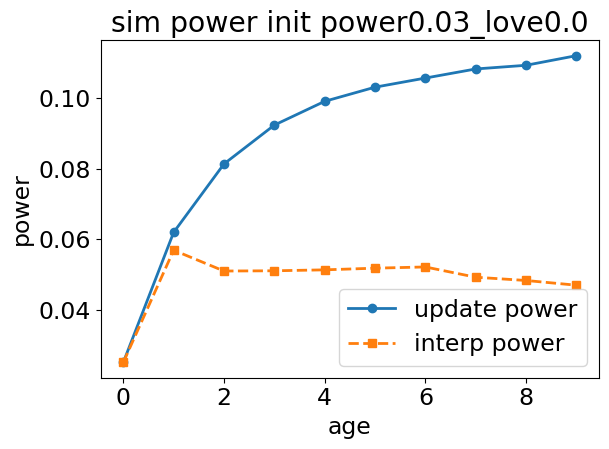

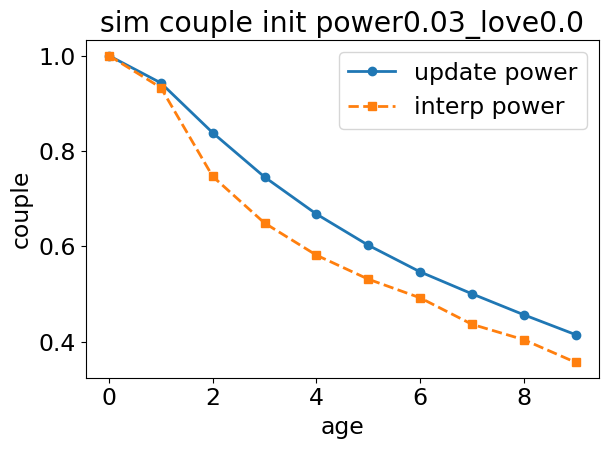

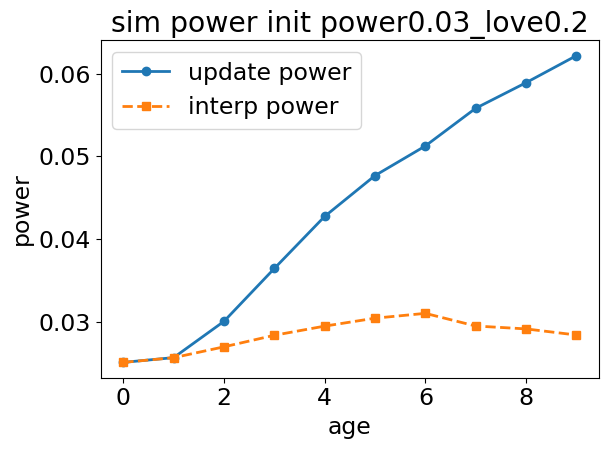

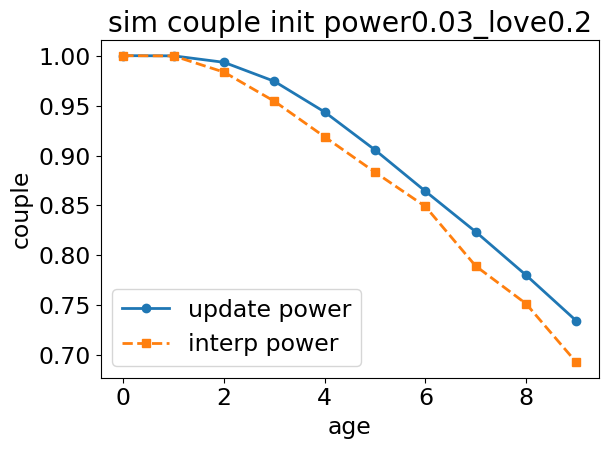

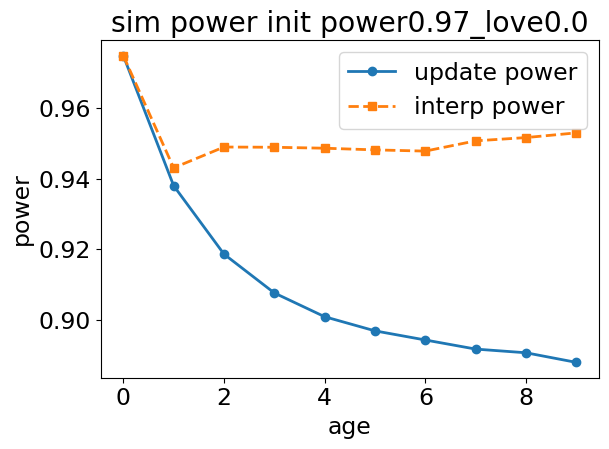

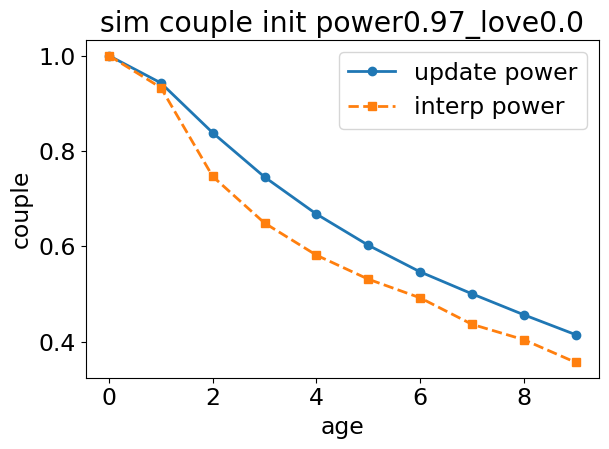

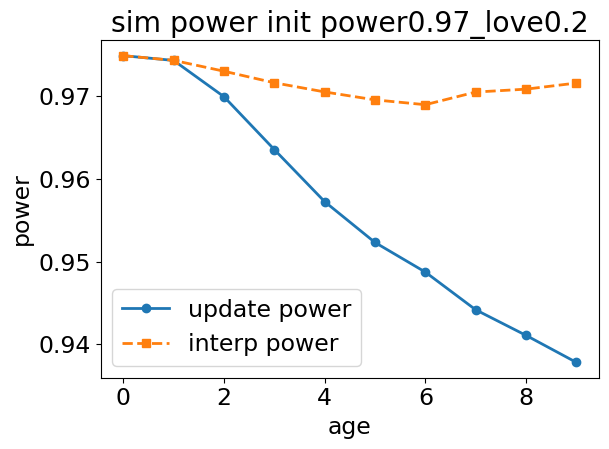

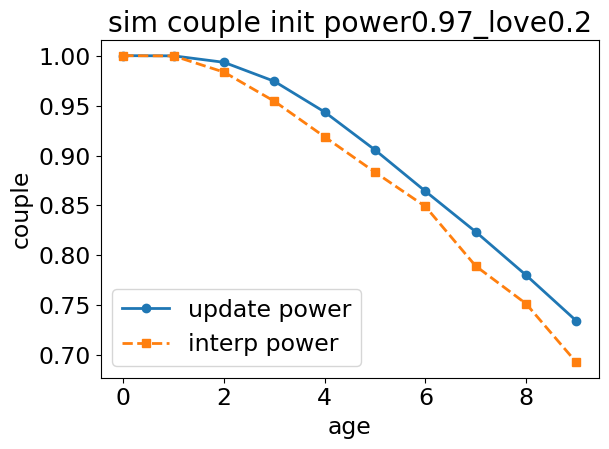

In [6]:
var_list = ('power','couple')
model_list = ('model 1','model 2')
SAVE = False
for init_power_idx in (1,19):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.title(fig_name)
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')

### Differences in simulated behavior...

In [7]:
model1 = models['model 1']
par1 = model1.par
sol1 = model1.sol
sim1 = model1.sim

model2 = models['model 2']
par2 = model2.par
sol2 = model2.sol
sim2 = model2.sim

init_A = 0.
init_love = 0.02
init_power_idx = 4
init_power = par1.grid_power[init_power_idx]

model1.sim.init_A[:] = init_A
model1.sim.init_love[:] = init_love
model1.sim.init_power_idx[:] = init_power_idx
model1.simulate()

model2.sim.init_A[:] = init_A
model2.sim.init_love[:] = init_love
model2.sim.init_power_idx[:] = init_power_idx
model2.simulate()

Sw1 = sol1.Vw_remain_couple-sol1.Vw_single[:,np.newaxis, np.newaxis,:]
Sm1 = sol1.Vm_remain_couple-sol1.Vm_single[:,np.newaxis, np.newaxis,:]

Sw2 = sol2.Vw_remain_couple-sol2.Vw_single[:,np.newaxis, np.newaxis,:]
Sm2 = sol2.Vm_remain_couple-sol2.Vm_single[:,np.newaxis, np.newaxis,:]

In [8]:
# interpolate spousal surplus for sim1
simSw1 = np.zeros((par1.simN,par1.simT))
simSm1 = np.zeros((par1.simN,par1.simT))
for i in range(par1.simN):
    for t in range(par1.simT):
        A = sim1.A[i,t]
        love = sim1.love[i,t]
        power = sim1.power[i,t]
        simSw1[i,t] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,Sw1[t], power, love, A)
        simSm1[i,t] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,Sm1[t], power, love, A)

# interpolate spousal surplus for sim2
simSw2 = np.zeros((par2.simN,par2.simT))
simSm2 = np.zeros((par2.simN,par2.simT))
for i in range(par2.simN):
    for t in range(par2.simT):
        A = sim2.A[i,t]
        love = sim2.love[i,t]
        power = sim2.power[i,t]
        simSw2[i,t] = linear_interp.interp_3d(par2.grid_power,par2.grid_love,par2.grid_A,Sw2[t], power, love, A)
        simSm2[i,t] = linear_interp.interp_3d(par2.grid_power,par2.grid_love,par2.grid_A,Sm2[t], power, love, A)

In [9]:
A = sim1.A[0,0]
power = sim1.power[0,0]

sol_power = np.zeros(par1.num_love)
for iP in range(par1.num_love):
    love = par1.grid_love[iP]
    sol_power[iP] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,sol1.power[0], power, love, A)

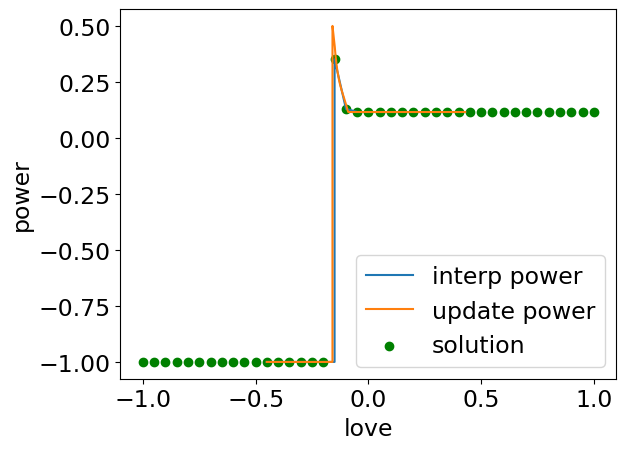

In [10]:
I1 = np.argsort(sim1.love[:,1])
I2 = np.argsort(sim2.love[:,1])

plt.plot(sim2.love[I2,1], sim2.power[I2,1], label='interp power')
plt.plot(sim1.love[I1,1], sim1.power[I1,1], label='update power')
plt.scatter(par1.grid_love, sol_power, color='green', label='solution')

# label axes
plt.xlabel('love')
plt.ylabel('power')
plt.legend();

(-0.2, -0.05)

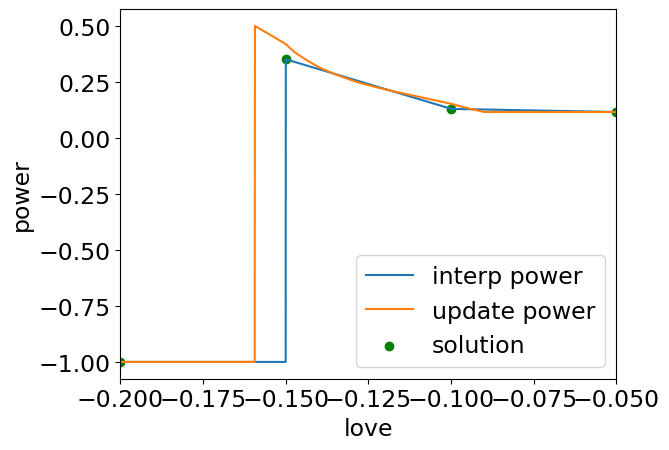

In [11]:
I1 = np.argsort(sim1.love[:,1])
I2 = np.argsort(sim2.love[:,1])

plt.plot(sim2.love[I2,1], sim2.power[I2,1], label='interp power')
plt.plot(sim1.love[I1,1], sim1.power[I1,1], label='update power')
plt.scatter(par1.grid_love, sol_power, color='green', label='solution')

# label axes
plt.xlabel('love')
plt.ylabel('power')
plt.legend()

# limit x axis
plt.xlim([-0.2,-0.05])